In [1]:
!pip install pymysql -q
!pip install plotly -q
!pip install sqlalchemy -q

     |████████████████████████████████| 43 kB 1.9 MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import datetime

# 데이터베이스 연결
import sqlalchemy as db
import pymysql

<br>
<br>

#### 데이터베이스 연결 및 테이블 콜 함수

* 유찰물량 데이터: 2019.01.01 ~
* 반입물량 데이터: 2019.01.01 ~
* 유가 데이터: 2016.01.01 ~
* 기상 데이터: 2016.01.01 ~

In [3]:
# floway_user는 SELECT 권한만 가지고 있음
engine = db.create_engine(
    '***')

metadata = db.MetaData()

In [70]:
# 10월이 '10' 아닌 '1'로 불러지는 문제 => 해결
def select_customs(f_type_nm):

    sql = """
    SELECT date, impWgt
      FROM(
        SELECT date_format(CONCAT(yr, '-', mont, '-', '01'), '%Y-%m-%d') AS date,
            statKor,
            impWgt
        FROM (
            SELECT
                  SUBSTR(YEAR, 1,4) AS yr,
                  CASE
                      WHEN SUBSTR(YEAR, 6,2) = '1' THEN 10
                      ELSE SUBSTR(YEAR, 6,2)
                  END AS mont,
                  statKor,
                  impWgt
            FROM customs
            WHERE statKor = '{0}') AS subtable ) AS subtable2
    WHERE DATE(date) between DATE_FORMAT('2016-01-01','%y-%m-%d') and  CURDATE()
    """.format(f_type_nm)

    return_body = engine.connect().execute(db.text(sql))
    f_rtn = return_body.fetchall()

    return f_rtn
  
def select_oil():

    sql = """
    SELECT o_date, AVG_PRICE
    FROM (SELECT o_date,
                avg(o_price) AS AVG_PRICE
          FROM opinet
          GROUP BY o_date) AS SUBTABLE
    WHERE DATE(o_date) between DATE_FORMAT('2017-01-01','%y-%m-%d') and  CURDATE()

    """

    return_body = engine.connect().execute(db.text(sql))
    f_rtn = return_body.fetchall()

    return f_rtn

def select_day_qnt_data(f_type_nm, f_name_nm, page):

    sql = """
    SELECT date,
          f_type,
          f_name,
          f_level,
          tot_qty
    FROM public_data
    WHERE f_type = '{0}' AND f_name = '{1}'
    AND DATE(date) between DATE_FORMAT('2017-01-01','%y-%m-%d') and  CURDATE()
    LIMIT 300
    OFFSET {2}
    """.format(f_type_nm, f_name_nm, (int(page)-1)*300)

    return_body = engine.connect().execute(db.text(sql))
    f_rtn = return_body.fetchall()

    return f_rtn

def select_yr_qnt_data(f_type_nm):

    sql = """
    SELECT date_format(CONCAT(YEAR(y_date), '-01-01'), '%Y-%m-%d'), 
        y_f_type,
        sum(y_tot_cnt)
    FROM yuchal_data 
    WHERE y_f_type = '{0}'
    GROUP BY YEAR(y_date),
             y_f_type
    """.format(f_type_nm)

    return_body = engine.connect().execute(db.text(sql))
    f_rtn = return_body.fetchall()

    return f_rtn

def select_weather_data(page):

    sql = """
    SELECT tm, 
          maxTa,
          minTa, 
          sumRn, 
          avgRhm,
          sumSsHr
    FROM daily_weather 
    WHERE stnId = 119 AND 
    DATE(tm) between DATE_FORMAT('2017-01-01','%y-%m-%d') and  CURDATE()
    LIMIT 300
    OFFSET {0}
    """.format((int(page)-1)*300)

    return_body = engine.connect().execute(db.text(sql))
    f_rtn = return_body.fetchall()

    return f_rtn


In [ ]:
# 잘 불러지는지 확인
# pd.DataFrame(select_customs('장미'))  # 날짜포맷 2019-01-01
# select_oil() # 한번에 다 불러옴. 날짜포맷 2019-01-01 ~ 현재
# pd.DataFrame(select_day_qnt_data('장미','비탈', 1)) # 날짜포맷 2016-01-01
# pd.DataFrame(select_weather_data(1)) # 날짜포맷 2016-01-01
# pd.DataFrame(select_yr_qnt_data('장미')) # 날짜포맷 2016-01-01


<br>
<br>

### 데이터 파이프라인, 전처리 함수

**전처리 내용** <br>
- 모든 데이터 기록단위를 일간으로 변경
- 2019.01.01~2022.05.?? 으로 데이터 기간 확정
- weather 결측치 처리 (변수 따라 상이)
- 품종별 output에서 결측치 처리 (==0)

<br>
<br>

**데이터 전처리 Summary**

|DB 테이블/함수명|기록단위(전)|기록단위(후)|기간(전)|기간(후)|비고|
|:----:|:---:|:---:|:---:|:---:|:---|
|customs|월간|일간|2016.01~|2017.01.01~||
|oil|일간|일간|2016.01.01~|2017.01.01~||
|select_day_qnt_data(public)|일간|일간|2016.01.01~|2017.01.01~| 최종단위: f_name </br>output 2개 -> t-2 lag 변수, label 데이터셋|
|select_yr_qnt_data(yuchal)|연간|일간|2016.01.04~|2017.01.01~||
|weather|일간|일간|2016.01.01~|2017.01.01~|결측치 보정 필요|

<br>
<br>

#### 분할해서 확인

In [93]:
#oil
base_df = pd.DataFrame()
tmp_df = pd.DataFrame(select_oil())
base_df = pd.concat([base_df, tmp_df], axis = 1)
base_df.rename(columns={0:"date", 1:"oil"}, inplace = True)
base_df.head()

,date,oil
0,2019-01-01,808.753351
1,2019-01-02,808.594431
2,2019-01-03,808.237101
3,2019-01-04,807.672785
4,2019-01-05,807.138581


In [94]:
#weather
tmp1 = pd.DataFrame()
page = 1
while 1:
  tmp2 = pd.DataFrame(select_weather_data(page))
  print(tmp2.head(1))
  tmp1 = pd.concat([tmp1, tmp2])
  page += 1
  if len(tmp2) < 300:
    break

tmp1.columns = ['date','maxTa','minTa','sumRn','avgRhm','sumSsHr']
base_df = base_df.merge(tmp1, how = 'outer', on='date')
base_df.head()

            0    1    2   3     4    5
0  2019-01-01  0.2 -9.0 NaN  64.8  5.3
            0     1    2    3     4    5
0  2019-10-28  17.4  6.3  2.7  79.6  7.3
            0     1     2   3     4    5
0  2020-08-23  30.4  21.7 NaN  83.1  9.1
            0     1     2   3     4     5
0  2021-06-19  27.4  17.6 NaN  81.4  11.4
            0     1    2   3     4     5
0  2022-04-15  17.3  7.3 NaN  57.9  11.7


,date,oil,maxTa,minTa,sumRn,avgRhm,sumSsHr
0,2019-01-01,808.753351,0.2,-9.0,NaN,64.8,5.3
1,2019-01-02,808.594431,1.5,-10.7,NaN,61.1,9.0
2,2019-01-03,808.237101,4.2,-10.1,NaN,52.3,9.1
3,2019-01-04,807.672785,4.2,-8.7,NaN,73.9,3.7
4,2019-01-05,807.138581,2.8,-6.4,NaN,45.0,8.8


In [95]:
#daily tot, lag2
tmp1 = pd.DataFrame()
page = 1
while 1:
  tmp2 = pd.DataFrame(select_day_qnt_data('장미','비탈',page))
  print(tmp2.head(1))
  tmp1 = pd.concat([tmp1, tmp2])
  page += 1
  if len(tmp2) < 300:
    break

tmp1.columns = ['date', 'f_type', 'f_name', 'f_level', 'tot_qty']

# 여기부터 date, f_type, f_name별 qty 값 합산한 df 로 변경
tmp1 = tmp1.groupby(["date", "f_type", "f_name"])['tot_qty'].sum().reset_index()
base_df = base_df.merge(tmp1, how = 'outer', on='date')
base_df.drop(columns=["f_type", "f_name"], inplace = True)
base_df.rename(columns={"tot_qty":"label"}, inplace = True)
base_df['daily_qty_lag2'] =  base_df['label'].shift(2)

            0   1   2   3     4
0  2019-01-02  장미  비탈  상1  1122
            0   1   2   3   4
0  2019-05-01  장미  비탈  상3  48
            0   1   2   3    4
0  2019-08-26  장미  비탈  상3  289
            0   1   2   3    4
0  2019-12-09  장미  비탈  상2  141
            0   1   2   3    4
0  2020-04-13  장미  비탈  상1  133
            0   1   2   3    4
0  2020-08-24  장미  비탈  특2  345
            0   1   2   3    4
0  2020-12-30  장미  비탈  특2  395
            0   1   2   3    4
0  2021-05-21  장미  비탈  특1  336
            0   1   2   3    4
0  2021-10-18  장미  비탈  특2  327
            0   1   2   3    4
0  2022-03-11  장미  비탈  특3  378


In [98]:
# custom
tmp1 = pd.DataFrame(select_customs("장미"))
tmp1.columns = ['date', 'impWgt']

tmp1['impWgt_lag365'] = tmp1['impWgt'].shift(12) # 한 해 전 자료가 앞으로 오게 함
tmp1.drop(columns=['impWgt'], inplace = True) # 변수 드랍
tmp1 = tmp1.iloc[12:][:] # 2018년 자료 드랍

tmp1['date'] = tmp1['date'].astype("str")
base_df['date'] = base_df['date'].astype("str")

base_df = base_df.set_index('date') #join(행 인덱스를 기준으로 결합)하기 위해 set_index
base_df = tmp1.set_index('date')

base_df = base_tmp.join(base_df, how = 'outer') #데이터프레임 결합
base_df

,oil,maxTa,minTa,sumRn,avgRhm,sumSsHr,label,daily_qty_lag2,impWgt_lag365
date,,,,,,,,,
2019-01-01,808.753351,0.2,-9.0,NaN,64.8,5.3,NaN,NaN,29612.0
2019-01-02,808.594431,1.5,-10.7,NaN,61.1,9.0,3175.0,NaN,NaN
2019-01-03,808.237101,4.2,-10.1,NaN,52.3,9.1,NaN,NaN,NaN
2019-01-04,807.672785,4.2,-8.7,NaN,73.9,3.7,1880.0,3175.0,NaN
2019-01-05,807.138581,2.8,-6.4,NaN,45.0,8.8,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-07-14,1477.605214,29.0,22.6,0.8,90.4,3.9,NaN,NaN,NaN
2022-07-15,1483.236824,29.9,21.9,NaN,81.9,11.0,1044.0,439.0,NaN
2022-07-16,1464.137929,29.4,22.6,NaN,81.0,9.4,NaN,NaN,NaN


In [112]:
# yearly tot
tmp1 = pd.DataFrame(select_yr_qnt_data('장미'))
tmp1.columns = ['date', 'f_type', 'yr_qty']
tmp1['yr_qty_lag365'] = tmp1['yr_qty'].shift(1)
tmp1.drop(columns=['f_type', 'yr_qty'], inplace = True)
tmp1 = tmp1.iloc[3:][:]
tmp1['date'] = tmp1['date'].astype(str)

tmp1.set_index('date', inplace = True)

base_df = base_df.join(tmp1, how = 'outer') #데이터프레임 결합
base_df

,oil,maxTa,minTa,sumRn,avgRhm,sumSsHr,label,daily_qty_lag2,impWgt_lag365,yr_qty_lag365
date,,,,,,,,,,
2019-01-01,808.753351,0.2,-9.0,NaN,64.8,5.3,NaN,NaN,29612.0,2658413
2019-01-02,808.594431,1.5,-10.7,NaN,61.1,9.0,3175.0,NaN,NaN,NaN
2019-01-03,808.237101,4.2,-10.1,NaN,52.3,9.1,NaN,NaN,NaN,NaN
2019-01-04,807.672785,4.2,-8.7,NaN,73.9,3.7,1880.0,3175.0,NaN,NaN
2019-01-05,807.138581,2.8,-6.4,NaN,45.0,8.8,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-07-14,1477.605214,29.0,22.6,0.8,90.4,3.9,NaN,NaN,NaN,NaN
2022-07-15,1483.236824,29.9,21.9,NaN,81.9,11.0,1044.0,439.0,NaN,NaN
2022-07-16,1464.137929,29.4,22.6,NaN,81.0,9.4,NaN,NaN,NaN,NaN


#### 데이터 파이프라인 결과

In [72]:
def creat_dataset(f_type:str, f_name:str):

  base_df = pd.DataFrame()
  
  # 1. oil 추출 및 병합
  tmp_df = pd.DataFrame(select_oil())
  base_df = pd.concat([base_df, tmp_df], axis = 1)
  base_df.rename(columns={0:"date", 1:"oil"}, inplace = True)

  print("the process is done with oil data")

  # 2. weather 추출 및 병합
  tmp1 = pd.DataFrame()
  page = 1
  while 1:
    tmp2 = pd.DataFrame(select_weather_data(page))
    tmp1 = pd.concat([tmp1, tmp2])
    page += 1
    if len(tmp2) < 300:
      break
  tmp1.columns = ['date','maxTa','minTa','sumRn','avgRhm','sumSsHr']

  base_df = base_df.merge(tmp1, how = 'outer', on='date')

  print("the process is done with weather data")


  # 3. 일일 경매유통량 추출 및 label 변수, lag 변수 병합 
  # 3.1 label 변수
  tmp1 = pd.DataFrame()
  page = 1
  while 1:
    tmp2 = pd.DataFrame(select_day_qnt_data(f_type, f_name, page))
    tmp1 = pd.concat([tmp1, tmp2])
    page += 1
    if len(tmp2) < 300:
      break
  tmp1.columns = ['date', 'f_type', 'f_name', 'f_level', 'tot_qty']

  tmp1 = tmp1.groupby(["date", "f_type", "f_name"])['tot_qty'].sum().reset_index()
  base_df = base_df.merge(tmp1, how = 'outer', on='date')
  base_df.drop(columns=["f_type", "f_name"], inplace = True)
  base_df.rename(columns={"tot_qty":"label"}, inplace = True)

  # 3.2 lag 변수
  base_df['daily_qty_lag2'] =  base_df['label'].shift(-2)

  print("the process is done with daily_qnt data")


  # 4. 전년도 월간 수입량
  tmp1 = pd.DataFrame(select_customs(f_type))
  tmp1.columns = ['date', 'impWgt']

  tmp1['impWgt_lag365'] = tmp1['impWgt'].shift(12) # 한 해 전 자료가 앞으로 오게 함
  tmp1.drop(columns=['impWgt'], inplace = True) # 변수 드랍
  tmp1 = tmp1.iloc[12:][:] # 2016년 자료 12개월(12행) 드랍

  tmp1['date'] = tmp1['date'].astype("str")
  base_df['date'] = base_df['date'].astype("str")

  base_df = base_df.set_index('date') #join(행 인덱스를 기준으로 결합)하기 위해 set_index
  tmp1 = tmp1.set_index('date')

  base_df = base_df.join(tmp1, how = 'outer') #데이터프레임 결합
  
  print("the process is done with customs data")

  # 5. 전년도 시장 반입량
  tmp1 = pd.DataFrame(select_yr_qnt_data(f_type))
  tmp1.columns = ['date', 'f_type', 'yr_qty']
  tmp1['yr_qty_lag365'] = tmp1['yr_qty'].shift(1)
  tmp1.drop(columns=['f_type', 'yr_qty'], inplace = True)
  tmp1 = tmp1.iloc[:][1:] # 2016년 자료 1개 드랍
  tmp1['date'] = tmp1['date'].astype(str)

  tmp1.set_index('date', inplace = True)

  base_df = base_df.join(tmp1, how = 'outer') #데이터프레임 결합
  print("the process is done with yr_qnt data")

  return base_df

In [ ]:
# df_rose_bital = creat_dataset('장미', '비탈')
# df_rose_bital

<br>
<br>

#### 데이터 전처리 파이프라인
1. FEATURE
  1. 결측치 처리
    * oil - 결측치 없음
    * weather - 결측치 있는 편
        * maxTa(최고온도), minTa(최저온도), avgRhm(평균 상대습도) = 앞선 값으로 채우기
        * sumRn(일일 강수량), sumSsHr (합계 일조시간) = 0.001으로
    * daily_qnt_lag2 - 장이 열리지 않은 날은 결측치임. 앞선 값으로 FILL
    * impWgt_lag365 - 매달 동일 값으로 (전년 수입량)
    * yr_qnt_lag365 - 매년 동일 값으로 (전년 유통량)
  1. 정규화
    * MIN-MAX?
    * N(0,1) 정규화?

2. LABEL
  1. 결측치 처리
    * label - 장이 열리지 않은 날 결측치 = 앞선 값으로 FILL
  2. 정규화 하지 않음




#### 전처리 파이프라인 함수 3개
* fill_na(df) -> df_fillna
* split_data_target(df_fillna) -> df_data, df_target
  * (중간에 train test split 해줘야함)
* feature_transformer(x_train, x_test) -> x_train_transformed, x_test_transformed

In [74]:
def fill_na(df):

  val_dict = {'sumRn':0.001, 'sumSsHr':0.001 }
  df.fillna(value = val_dict, inplace = True)

  df['maxTa'] = df['maxTa'].fillna(method='ffill')
  df['minTa'] = df['minTa'].fillna(method='ffill')
  df['avgRhm'] = df['avgRhm'].fillna(method='ffill')
  df['label'] = df['label'].fillna(method='ffill')
  df['daily_qty_lag2'] = df['daily_qty_lag2'].fillna(method='ffill')
  df['impWgt_lag365'] = df['impWgt_lag365'].fillna(method='ffill')
  df['yr_qty_lag365'] = df['yr_qty_lag365'].fillna(method='ffill')

  #마지막으로 1번째 행 결측치 채우기
  df['label'] = df['label'].fillna(method='bfill')
  df['daily_qty_lag2'] = df['daily_qty_lag2'].fillna(method='bfill')


  # split 위해서 열 순서 변경
  df=df[['oil', 'maxTa', 'minTa', 'sumRn', 'avgRhm', 'sumSsHr',
       'daily_qty_lag2', 'impWgt_lag365', 'yr_qty_lag365',  'label']]
  
  return df

In [ ]:
# df_rose_bital_fillna = fill_na(df_rose_bital)
# df_rose_bital_fillna

In [76]:
def split_data_target(df_fillna):

  df_data = df_fillna.drop(columns = ['label'])
  df_target = df_fillna[['label']]

  return df_data, df_target

In [ ]:
# df_data, df_target = split_data_target(df_rose_bital)
# df_data.shape, df_target.shape

In [78]:
from sklearn import model_selection
x_train, x_test, y_train, y_test = model_selection.train_test_split(df_data, 
                                                                    df_target, 
                                                                    test_size=0.2, 
                                                                    random_state=1004)

In [79]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer # preprocessor 만들 때
from sklearn.pipeline import Pipeline

def feature_transformer(x_train, x_test):

  # 숫자형 변수명을 리스트로 모으로 스케일링 인스턴스 생성 (label변수 제외)
  numeric_features = list(x_train.columns)
  numeric_transformer =StandardScaler()  

  # 전처리 도구들 준비하기 : preprocessor라는 이름으로 묶어서
  preprocessor = ColumnTransformer(
      transformers=[ #(name, transformer, column(s))의 튜플들로 이루어진 리스트
        ('num', numeric_transformer, numeric_features)])
  
  preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)])
  preprocessor_pipe.fit(x_train)
  x_train_transformed = preprocessor_pipe.transform(x_train)
  x_test_transformed = preprocessor_pipe.transform(x_test)

  return x_train_transformed, x_test_transformed

In [80]:
# x_train_transformed, x_test_transformed = feature_transformer(x_train, x_test)

In [ ]:
# y_train.shape, y_test.shape

<br>
<br>

### 데이터 읽어들이기

In [ ]:
# 꽃 품종, 품명에 따라 데이터 불러오기
df = creat_dataset('거베라', '비탈')

# 결측치 채우고 data, target 분할
df_fillna = fill_na(df)
df_data, df_target = split_data_target(df_fillna)

# train set, test set  분할
from sklearn import model_selection
x_train, x_test, y_train, y_test = model_selection.train_test_split(df_data, 
                                                                    df_target, 
                                                                    test_size=0.2, 
                                                                    random_state=1004)

# train 과 test 모두 standard scaling (train 기준)
x_train_transformed, x_test_transformed = feature_transformer(x_train, x_test)


In [82]:
print(x_train_transformed.shape)
print(x_test_transformed.shape)
print(y_train.shape)
print(y_test.shape)

(1620, 9)
(405, 9)
(1620, 1)
(405, 1)


<br>
<br>

### 비어있는 모델 객체 만들고 학습

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

NameError: ignored

<br>
<br>

#### 모델 객체 학습시키기 (on training data)

*   https://codingapple.com/unit/deep-learning-stock-price-ai/
*   https://koreascience.kr/article/JAKO201809469053682.pdf
* https://dschloe.github.io/python/python_edu/07_deeplearning/deep_learning_lstm/#5-%EB%AA%A8%ED%98%95-%ED%95%99%EC%8A%B5
* https://shpk333.tistory.com/entry/MYSQL-SELECT%EB%AC%B8-WHERE-%EC%A1%B0%EA%B1%B4%EC%97%90%EC%84%9C-%EB%82%A0%EC%A7%9CDATE%EB%A5%BC-%ED%86%B5%ED%95%9C-%EA%B2%80%EC%83%89-%EC%82%AC%EC%9A%A9%EB%B2%95-%EB%B0%8F-%EC%98%88%EC%A0%9C
* https://seulhee030.tistory.com/51
* https://blog.dork94.com/194





In [ ]:

# Train the model using the training sets

model.?(x_train, y_train) # 모델에 데이터를 '맞춰줍니다'

In [ ]:
print('Coefficients: ', model.?)

Coefficients:  [[-0.96814078]]


In [ ]:
print('Intercepts: ', model.?)

In [ ]:
# y = ? x + ?

<br>
<br>

### 학습이 끝난 모델 테스트하기 (on test data)

In [ ]:
model.predict(x_train) # '예측하다'

In [ ]:
# 354개 Train 데이터에 대한 Model 의 Mean squared error 
print('MSE(Training data) : ', np.mean((model.predict(x_train) - y_train) ** 2))

Mean squared error: 37.933978172880295


In [ ]:
# Use this!
from sklearn.metrics import ?

print('MSE(Training data) : ', ?(model.predict(x_train), y_train))

MSE:  37.9339781729


In [ ]:
# 152개 Test 데이터에 대한 Model 의 Mean squared error 
print('MSE(Test data) : ', ?(model.predict(x_test), y_test))

MSE(Test data) :  39.8171505047


In [ ]:
# Square root of error
np.sqrt( ?(model.predict(x_test), y_test) )

6.3100832407143539

<br>
<br>

### 모델 시각화

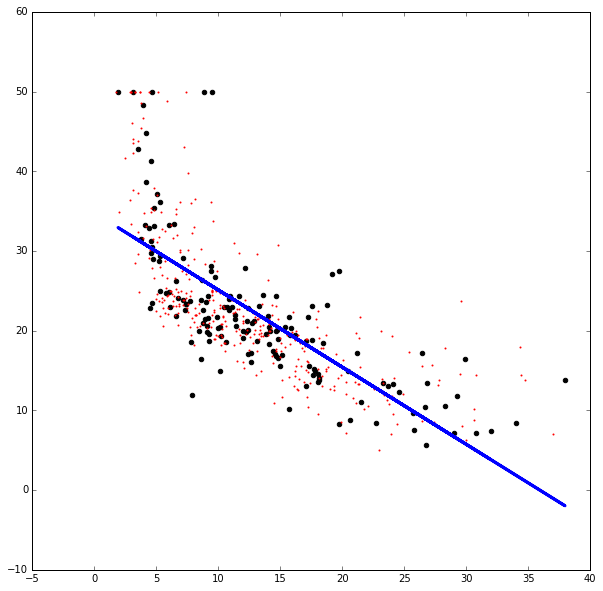

In [ ]:
plt.figure(figsize=(10, 10))

plt.scatter(x_test, y_test, color="black") # Test data
plt.scatter(x_train, y_train, color="red", s=1) # Train data

plt.plot(x_test, model.predict(x_test), color="blue", linewidth=3) # Fitted line

plt.show()

<br>
<br>

#### Practice. 더 좋은 성능을 보이는 Feature 를 찾아보세요!

MSE(Training data) :  37.9339781729
MSE(Test data) :  39.8171505047


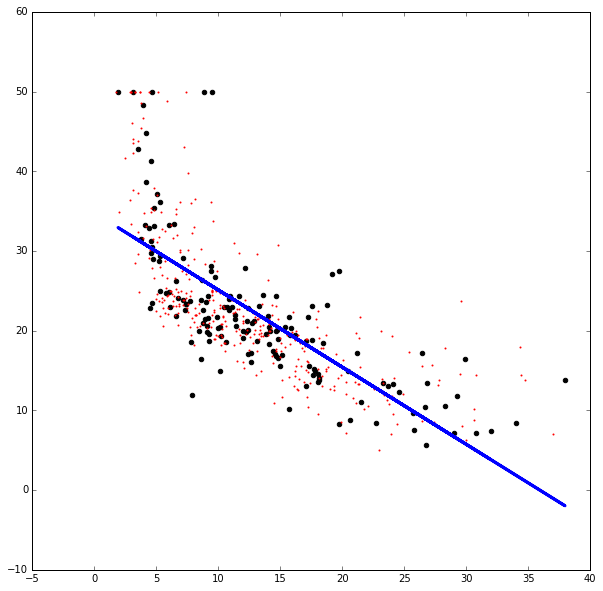

In [ ]:
from sklearn import model_selection, linear_model
from sklearn.metrics import mean_squared_error

# 1. Prepare the data (array!)
boston_data = np.array(df_data)
boston_target = np.array(df_target)

# 2. Feature selection
boston_X = boston_data[:, 12:13] 
boston_Y = boston_target

# 3. Train/Test split
x_train, x_test, y_train, y_test = model_selection.train_test_split(boston_X, boston_Y, test_size=0.3, random_state=0)

# 4. Create model object 
model = linear_model.LinearRegression()

# 5. Train the model 
model.fit(x_train, y_train)

# 6. Test the model
print('MSE(Training data) : ', mean_squared_error(model.predict(x_train), y_train))
print('MSE(Test data) : ', mean_squared_error(model.predict(x_test), y_test))

# 7. Visualize the model
plt.figure(figsize=(10, 10))
plt.scatter(x_test, y_test, color="black") # Test data
plt.scatter(x_train, y_train, color="red", s=1) # Train data
plt.plot(x_test, model.predict(x_test), color="blue", linewidth=3) # Fitted line
plt.show()